In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mra
import selector as se

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)

# Create parameters

In [3]:
rho = 1.
K_i = num_points = 1 
eps_sublevel = percent = 0.1

num_resources = 50
num_agents = num_participants = 100

filename = "subgrad_resal_n%d_m%d"%(num_agents, num_resources)

In [4]:

num_resource_per_participant = 10
inner_size = 5

A_all, A_ineq, b_ineq = mra.resal_data(num_resources, num_participants, inner_size)

# CVXPY centralized solution

In [5]:
true_x, true_f, true_lamb = mra.centralized_solution_resal(A_all, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-91.86415947259077


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

1.000000020813085

In [7]:
true_x.shape, true_lamb.shape

((5000, 1), (50, 1))

In [8]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions(lamb_k, i, A_all,  
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.resal_query_multiple_actions_noisy_prices(lamb_k, i, A_all,
                                                                         percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.resal_obj_value(x_k, A_all)

# Dual projected subgradient

In [9]:
price_max = 3 * true_lamb.max()
price_min = np.maximum(0, (1./3) * true_lamb.min())
alpha = 1 # proximal term coefficient
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

# Test

In [10]:
if isinstance(price_max, float):
    price_max = price_max * np.ones((b_ineq.size, 1))
    price_min = price_min * np.ones((b_ineq.size, 1))
lamb_k = (price_min + price_max) / 2
x_k = np.zeros((primal_var_size, 1))

last_idx = 0
for i in range(num_agents):
    xis = fun_agents_eps[i](lamb_k[:, 0], K=1, i=i)
    x_k[last_idx : last_idx + xis.shape[0], 0] = xis[:, 0]
    last_idx += xis.shape[0]

print((A_ineq @ x_k - b_ineq).max(), np.linalg.norm(A_ineq @ x_k - b_ineq))
print(np.sum(np.maximum(A_ineq @ x_k - b_ineq, 0))/np.linalg.norm(b_ineq), b_ineq.max())

89.99995440776337 244.8239493770045
0.3949084586555612 50.0


In [30]:
alpha_ks = ["0.1/sqrt(k)", "1/sqrt(k)", "1/k", "10/k"]
func_alphas = {"0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
               "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
               "1/k": lambda k: 1 / (k+1),
               "10/k": lambda k: 10 / (k+1)}

# subgrad_all_results, subgrad_lamb_k, subgrad_x_k, subgrad_primal_average
subgrad_all_results = {}
for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    subgrad_all_results[alpha_k]  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                             func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=50, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

alpha_k='0.1/sqrt(k)'


/Users/tepars/Documents/postdoc/mra_primal_rec/mra/subgrad.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=1.2359E-02,  f_subopt_mra=1.2359E-02,  viol_xk=9.6606E+01, viol_mra=9.6606E+01, lamb_rel_diff=9.3669E-01
alpha_k='1/sqrt(k)'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=5.5614E-02,  f_subopt_mra=5.5614E-02,  viol_xk=9.3374E+01, viol_mra=9.3374E+01, lamb_rel_diff=1.4142E+00
alpha_k='1/k'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=9.7246E+01, viol_mra=9.7246E+01, lamb_rel_diff=1.1151E+00
alpha_k='10/k'
epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=49, f_subopt_xk=5.5614E-02,  f_subopt_mra=5.5614E-02,  viol_xk=9.3374E+01, viol_mra=9.33

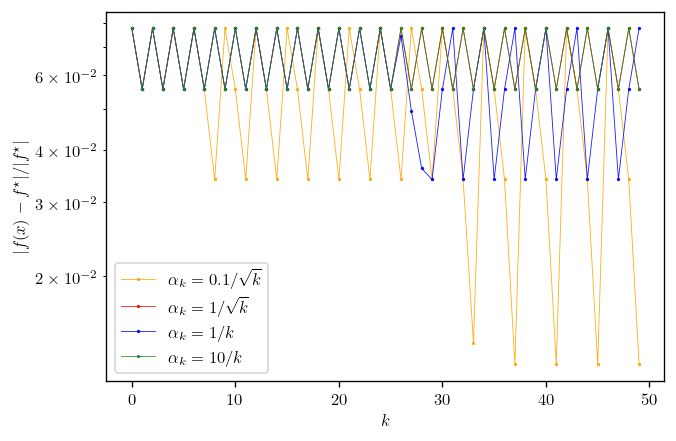

In [31]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          "1/sqrt(k)":r"$\alpha_k=1/\sqrt{k}$", 
          "1/k":r"$\alpha_k=1/k$", 
          "10/k":r"$\alpha_k=10/k$"}


for i, (alpha_k, label) in enumerate(labels.items()):
    axs.plot((np.abs(np.array(subgrad_all_results[alpha_k]["f_xk"]) - true_f))/np.abs(true_f), 
             color=cmp[i], label=label, alpha=0.9, lw=0.5, marker='.', markersize=2) 

axs.legend()
axs.set_ylabel(r"$|f(x) - f^\star|/|f^\star|$")
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("../plots/%s_func_subopt.pdf"%filename)

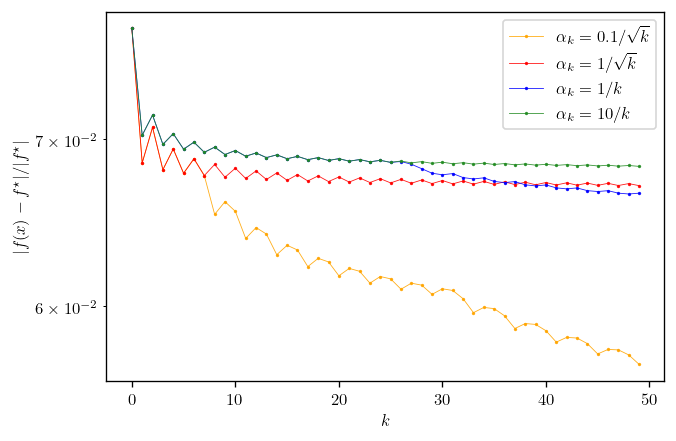

In [32]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          "1/sqrt(k)":r"$\alpha_k=1/\sqrt{k}$", 
          "1/k":r"$\alpha_k=1/k$", 
          "10/k":r"$\alpha_k=10/k$"}

for i, (alpha_k, label) in enumerate(labels.items()):
    axs.plot((np.abs(np.array(subgrad_all_results[alpha_k]["f_paver_xk"]) - true_f))/np.abs(true_f), 
             color=cmp[i], label=label, alpha=0.9, lw=0.5, marker='.', markersize=2) 

axs.legend()
axs.set_ylabel(r"$|f(x) - f^\star|/|f^\star|$")
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("plots/%s_func_paverage.pdf"%filename)

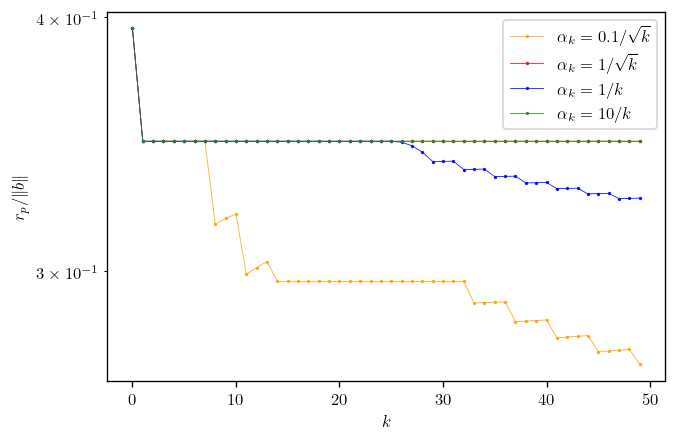

In [33]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          "1/sqrt(k)":r"$\alpha_k=1/\sqrt{k}$", 
          "1/k":r"$\alpha_k=1/k$", 
          "10/k":r"$\alpha_k=10/k$"}

for i, (alpha_k, label) in enumerate(labels.items()):
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_paver_xk"]) / np.linalg.norm(b_ineq), 
             color=cmp[i], label=label, alpha=0.9, lw=0.5, marker='.', markersize=2) 

axs.legend()
axs.set_ylabel(r'$r_p/\|b\|$')
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("plots/%s_viol_paverage.pdf"%filename)

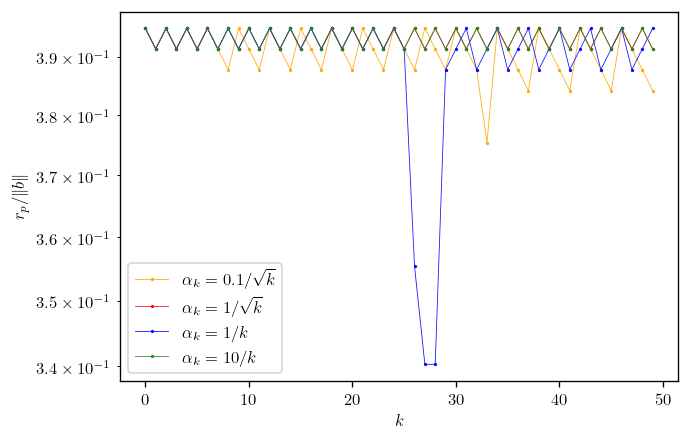

In [34]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          "1/sqrt(k)":r"$\alpha_k=1/\sqrt{k}$", 
          "1/k":r"$\alpha_k=1/k$", 
          "10/k":r"$\alpha_k=10/k$"
          }

for i, (alpha_k, label) in enumerate(labels.items()):
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_xk"]) / np.linalg.norm(b_ineq), 
             color=cmp[i], label=label, alpha=0.9, lw=0.5, marker='.', markersize=2) 

axs.legend()
axs.set_ylabel(r'$r_p/\|b\|$')
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("plots/%s_viol_xk.pdf"%filename)

# Best learning rate

In [18]:
func_alphas = {
    "0.1/sqrt(k)": lambda k: 0.1 / np.sqrt(k+1), 
            #    "1/sqrt(k)": lambda k: 1 / np.sqrt(k+1),
            #    "1/k": lambda k: 1 / (k+1),
            #    "10/k": lambda k: 10 / (k+1)
               }


for alpha_k, func_alpha_k in func_alphas.items():
    print(f"{alpha_k=}")
    subgrad_all_results, subgrad_lamb_k, _, subgrad_x_k, subgrad_primal_average, _  = mra.dual_proj_subgradient(fun_agents_eps, fun_obj_val, primal_var_size,
                                                            func_alpha_k, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=1000, 
                                                            true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)

alpha_k='0.1/sqrt(k)'


/Users/tepars/Documents/postdoc/mra_primal_rec/mra/subgrad.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  lamb_rel_diff = np.linalg.norm(lamb_k - lamb_prev) / np.linalg.norm(lamb_prev)


epoch=0, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=4.2108E+02, viol_mra=4.2108E+02, lamb_rel_diff=INF
epoch=50, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=9.9386E+01, viol_mra=9.9386E+01, lamb_rel_diff=9.6215E-01
epoch=100, f_subopt_xk=3.3956E-02,  f_subopt_mra=3.3956E-02,  viol_xk=9.8666E+01, viol_mra=9.8666E+01, lamb_rel_diff=8.7719E-01
epoch=150, f_subopt_xk=3.3956E-02,  f_subopt_mra=3.3956E-02,  viol_xk=1.0365E+02, viol_mra=1.0365E+02, lamb_rel_diff=6.9639E-01
epoch=200, f_subopt_xk=7.7579E-02,  f_subopt_mra=7.7579E-02,  viol_xk=1.1218E+02, viol_mra=1.1218E+02, lamb_rel_diff=7.2136E-01
epoch=250, f_subopt_xk=3.3956E-02,  f_subopt_mra=3.3956E-02,  viol_xk=1.0774E+02, viol_mra=1.0774E+02, lamb_rel_diff=6.0938E-01
epoch=300, f_subopt_xk=7.7578E-02,  f_subopt_mra=7.7578E-02,  viol_xk=1.1954E+02, viol_mra=1.1954E+02, lamb_rel_diff=6.3217E-01
epoch=350, f_subopt_xk=3.3956E-02,  f_subopt_mra=3.3956E-02,  viol_xk=1.0994E+02, viol_mra=1.0994E+02, lamb_rel_di

In [19]:
subgrad_all_results = {"0.1/sqrt(k)": subgrad_all_results}

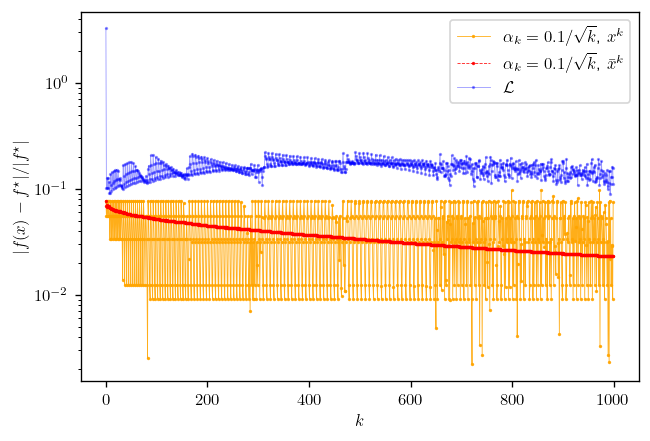

In [20]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          }


for i, (alpha_k, label) in enumerate(labels.items()):
    axs.plot((np.abs(np.array(subgrad_all_results[alpha_k]["f_xk"]) - true_f))/np.abs(true_f), 
             color=cmp[i], label=label + r", $x^k$", alpha=0.9, lw=0.5, marker='.', markersize=2) 

    axs.plot((np.abs(np.array(subgrad_all_results[alpha_k]["f_paver_xk"]) - true_f))/np.abs(true_f), 
             color=cmp[i+1], label=label + r", $\bar x^k$", alpha=0.9, lw=0.5, marker='.', ls='--', markersize=2) 
    
axs.plot((np.abs(np.array(subgrad_all_results[alpha_k]["lagr_xk"]) - true_f))/np.abs(true_f), 
             color=cmp[i+2], label="$\mathcal{L}$", alpha=0.4, lw=0.5, marker='.', markersize=2) 
    
axs.legend()
axs.set_ylabel(r"$|f(x) - f^\star|/|f^\star|$")
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("../plots/%s_func_subopt.pdf"%filename)

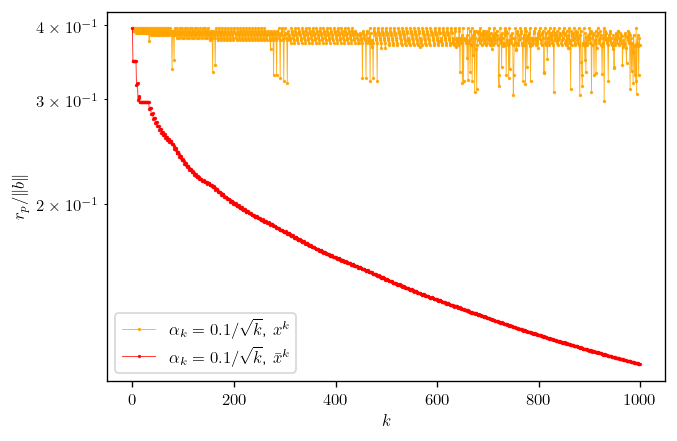

In [28]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          }

for i, (alpha_k, label) in enumerate(labels.items()): 
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_xk"]) / np.linalg.norm(b_ineq), 
             color=cmp[i], label=label + r", $x^k$", alpha=0.9, lw=0.5, marker='.', markersize=2) 
    
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_paver_xk"]) / np.linalg.norm(b_ineq), 
             color=cmp[i+1], label=label + r", $\bar x^k$", alpha=0.9, lw=0.5, marker='.', markersize=2)

axs.legend()
axs.set_ylabel(r'$r_p/\|b\|$')
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("plots/%s_viol_paverage.pdf"%filename)

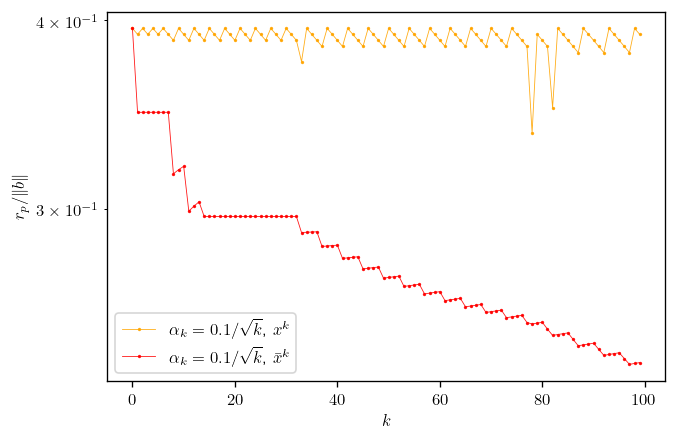

In [27]:
# cmp = sns.color_palette("hls", 5)
cmp = ["orange", "red", "blue", "forestgreen", "violet"]
fig, axs = plt.subplots(1, figsize=(6, 4), dpi=120)
labels = {"0.1/sqrt(k)":r"$\alpha_k=0.1/\sqrt{k}$", 
          }

for i, (alpha_k, label) in enumerate(labels.items()): 
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_xk"])[:100] / np.linalg.norm(b_ineq), 
             color=cmp[i], label=label + r", $x^k$", alpha=0.9, lw=0.5, marker='.', markersize=2) 
    
    axs.plot(np.array(subgrad_all_results[alpha_k]["viol_primal_paver_xk"])[:100] / np.linalg.norm(b_ineq), 
             color=cmp[i+1], label=label + r", $\bar x^k$", alpha=0.9, lw=0.5, marker='.', markersize=2)

axs.legend()
axs.set_ylabel(r'$r_p/\|b\|$')
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
# plt.savefig("plots/%s_viol_paverage.pdf"%filename)